In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

ImportError: cannot import name 'TubeTK' from 'itk' (/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/site-packages/itk/__init__.py)

In [9]:
img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

gpu_device = 0

num_classes = 3

max_epochs = 500

net_in_dim = 3
net_in_channels = 1
#net_channels=(32, 64, 128)
#net_strides=(2, 2)
net_channels=(32, 64, 128, 64)
net_strides=(2, 2, 2)
        
num_folds = 15

num_slices = 32
size_x = 160
size_y = 320

roi_size = (size_x,size_y,num_slices)

num_workers_te = 0
batch_size_te = 1

model_filename_base = "./results/BAMC_PTX_3DUNet-Middle-Extruded-NS.best_model.vfold"

num_images = len(all_images)
print(num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62 62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


In [10]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
    ]
)

In [11]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

tensor(1.)
Data Size = torch.Size([1, 1, 160, 320, 60])


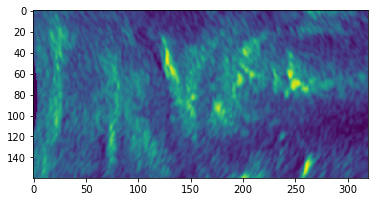

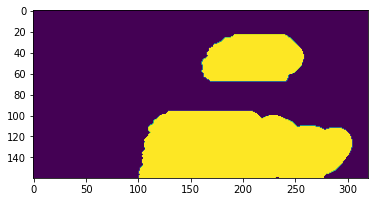

In [12]:
batchnum = 2
imgnum = 0
lbl = utils.first(test_loader[batchnum])["label"]
m = lbl[imgnum,0,:,:,24].max()
print(m)
if m == 1:
    img = utils.first(test_loader[0])["image"]
    plt.subplots()
    plt.imshow(img[imgnum,0,:,:,24])
    plt.subplots()
    plt.imshow(lbl[imgnum,0,:,:,24])
print("Data Size =", lbl.shape)

In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:"+str(gpu_device))

In [14]:
def plot_vfold_training_curves(vfold_num, test_loader, min_size_comp, min_portion_comp, p_prior, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
    
        metric_file = model_filename_base+"_val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dim,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            fname = os.path.basename(test_files[vfold_num][i]["image"])
            prevfname = fname
            count1 = 0
            count = 0
            for b,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][i]["image"])
                    
                    if fname[:22]!=prevfname[:22]:
                        #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
                        if count1 == count:
                            if graph:
                                print("  Winner = Sliding")
                            if prevfname[3] == 's':
                                correct += 1
                            else:
                                incorrect += 1
                                false_negatives += 1
                                print(" FN Patient =", prevfname)
                        else:
                            if graph:
                                print("  Winner = Not Sliding")
                            if prevfname[3] == 'n':
                                correct += 1
                            else:
                                incorrect += 1
                                print(" FP Patient =", prevfname)
                        if graph:
                            print()
                            print()
                        count1 = 0
                        count = 0
                    
                    prob_shape = test_outputs[j,:,:,:,:].shape
                    prob = np.empty(prob_shape)
                    for c in range(num_classes):
                        itkProb = itk.GetImageFromArray(test_outputs[j,c,:,:,:].cpu())
                        imMathProb = ttk.ImageMath.New(itkProb)
                        imMathProb.Blur(5)
                        itkProb = imMathProb.GetOutput()
                        prob[c] = itk.GetArrayFromImage(itkProb)
                    arrc1 = np.zeros(prob[0].shape)
                    if False:
                        arrc1 = np.argmax(prob,axis=0)
                    else:
                        pmin = prob[0].min()
                        pmax = prob[0].max()
                        for c in range(1,num_classes):
                            pmin = min(pmin, prob[c].min())
                            pmax = min(pmax, prob[c].max())
                        prange = pmax - pmin
                        prob = (prob - pmin) / prange
                        for c in range(num_classes):
                            prob[c] = prob[c] * p_prior[c]
                        arrc1 = np.argmax(prob,axis=0)
                    
                    max_size = np.count_nonzero(test_data["label"][j, 0, :, :, :].cpu()>0)
                    min_thresh = max(min_size_comp, max_size*min_portion_comp)
                    
                    itkc1 = itk.GetImageFromArray(arrc1.astype(np.float32))
                    imMathC1 = ttk.ImageMath.New(itkc1)
                    for c in range(num_classes):
                        imMathC1.Erode(10,c,0)
                        imMathC1.Dilate(10,c,0)
                    itkc1 = imMathC1.GetOutputUChar()
                    arrc1 = itk.GetArrayFromImage(itkc1)
                    slice_count1 = np.count_nonzero(arrc1==1)
                    slice_count2 = np.count_nonzero(arrc1==2)
                    slice_decision = "Unknown"
                    if slice_count2>slice_count1 and slice_count2>min_thresh:
                        count1 += 1
                        slice_decision = "Sliding"
                        if fname[3] == 's':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_false_negatives += 1
                            print("      FN ROI =", fname)
                    else:
                        slice_decision = "Not Sliding"
                        if fname[3] == 'n':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            print("      FP ROI =", fname)
                    count += 1
                    

                    if graph:
                        print(fname)

                        plt.figure("check", (18, 6))
                        plt.subplot(1, 3, 1)
                        plt.title(f"image {i}")
                        tmpV = test_data["image"][j, 0, :, :, 24]
                        plt.imshow(tmpV, cmap="gray")
                        plt.subplot(1, 3, 2)
                        plt.title(f"label {i}")
                        tmpV = test_data["label"][j, 0, :, :, 24]
                        tmpV[0,0]=1
                        tmpV[0,1]=2
                        plt.imshow(tmpV)
                        plt.subplot(1, 3, 3)
                        plt.title(f"output {i}")
                        arrc1[0,0,24]=1
                        arrc1[0,1,24]=2
                        plt.imshow(arrc1[:,:,24])
                        plt.show()

                        print("Number of not-sliding / sliding pixel =", slice_count1, slice_count2)
                        print("    Min thresh =", min_thresh)
                        print("   ", slice_decision)
                        print()
                        print()

                        for c in range(num_classes):
                            arrimg = test_outputs.detach().cpu()[j,c,:,:]
                            itkimg = itk.GetImageFromArray(arrimg)
                            filename = model_filename_base+"_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".nii.gz"
                            itk.imwrite(itkimg, filename)
                    
                    i += 1
                    
            #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print(" FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print(" FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

*************
Prior = [1.3, 1.0, 0.9]
   VFOLD = 0 of 15


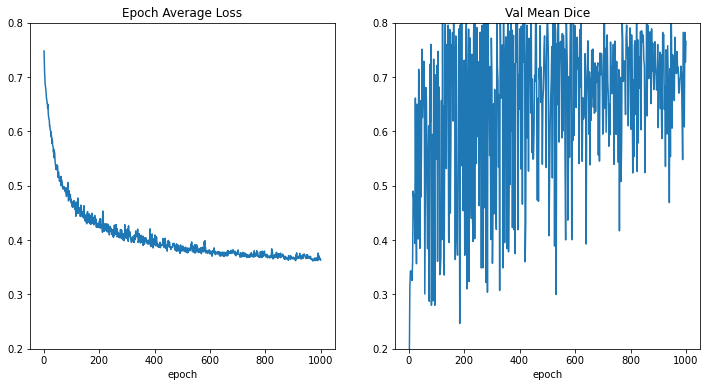

247ns_image_2734882394424_CLEAN.nii.gz


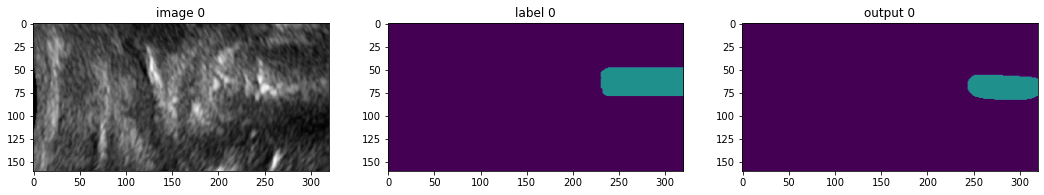

Number of not-sliding / sliding pixel = 114171 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


247ns_image_2743083265515_CLEAN.nii.gz


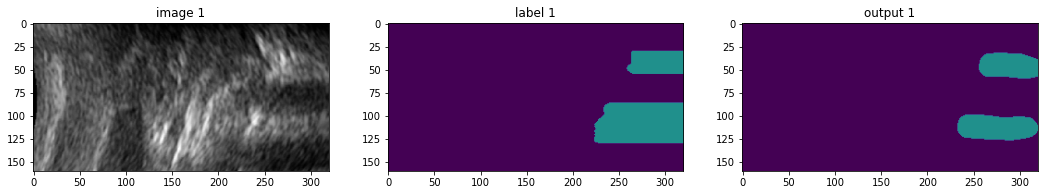

Number of not-sliding / sliding pixel = 227580 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FP ROI = 236s_iimage_1139765223418_CLEAN.nii.gz
236s_iimage_1139765223418_CLEAN.nii.gz


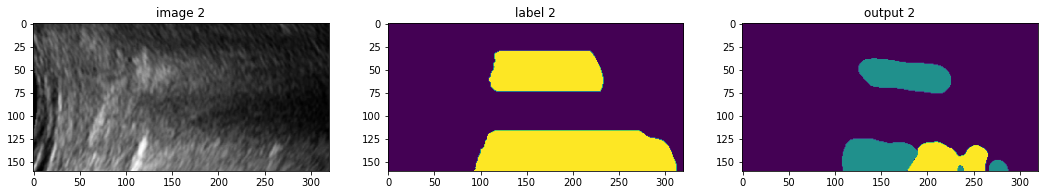

Number of not-sliding / sliding pixel = 319628 117879
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 236s_iimage_1139765223418_CLEAN.nii.gz


236s_iimage_1327616672148_clean.nii.gz


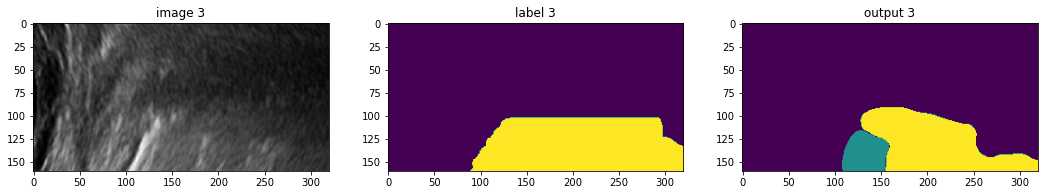

Number of not-sliding / sliding pixel = 58233 565483
    Min thresh = 1000
    Sliding


  Winner = Sliding


237s_iimage_24164968068436_CLEAN.nii.gz


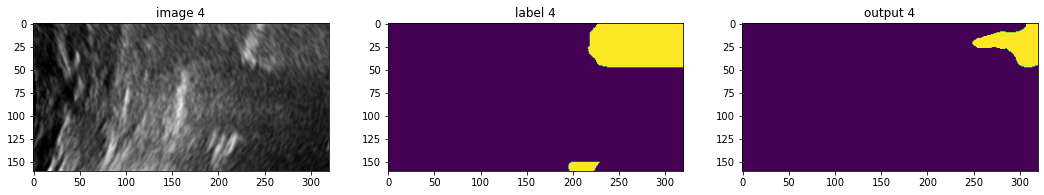

Number of not-sliding / sliding pixel = 0 161293
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 1 of 15


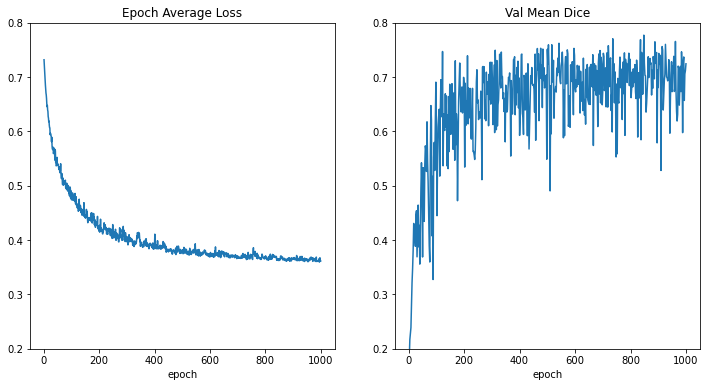

025ns_Image_262499828648_clean.nii.gz


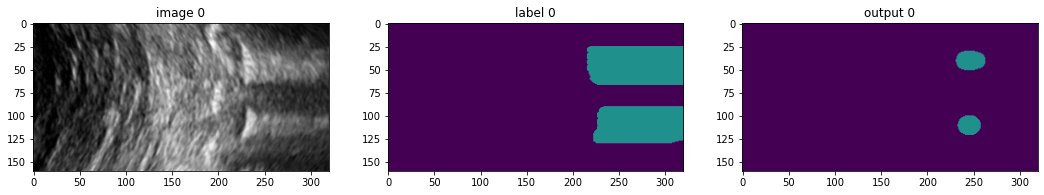

Number of not-sliding / sliding pixel = 90035 14591
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


025ns_image_267456908021_clean.nii.gz


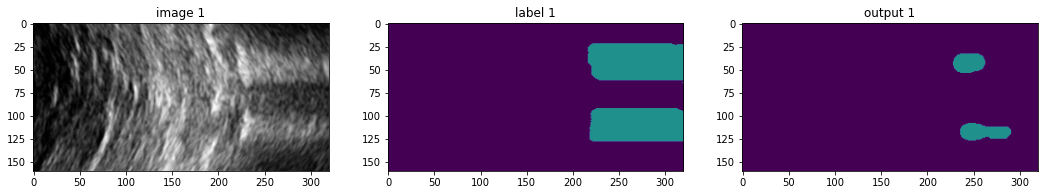

Number of not-sliding / sliding pixel = 62034 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FP ROI = 004s_iimage_73815992352100_clean.nii.gz
004s_iimage_73815992352100_clean.nii.gz


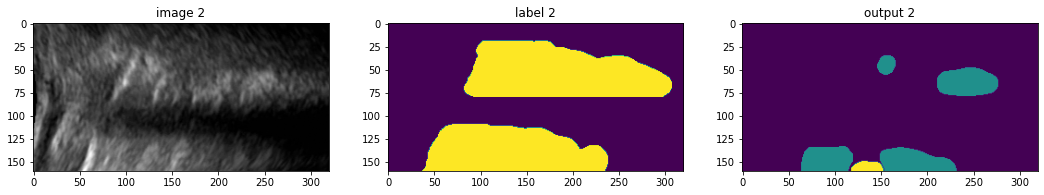

Number of not-sliding / sliding pixel = 272261 57557
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 004s_iimage_73815992352100_clean.nii.gz


      FP ROI = 004s_iimage_74132233134844_clean.nii.gz
004s_iimage_74132233134844_clean.nii.gz


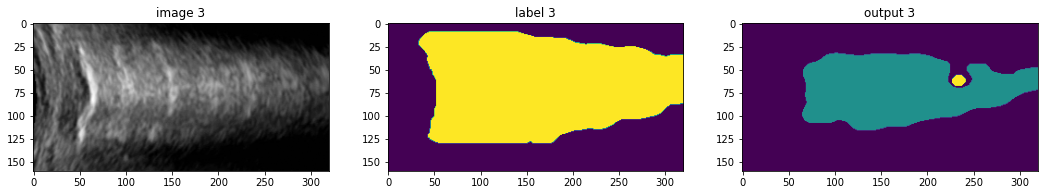

Number of not-sliding / sliding pixel = 796363 52526
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 004s_iimage_74132233134844_clean.nii.gz


   VFOLD = 2 of 15


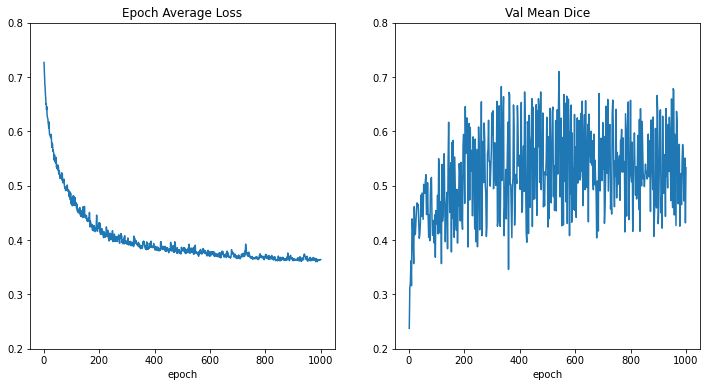

026ns_image_1083297968960_clean.nii.gz


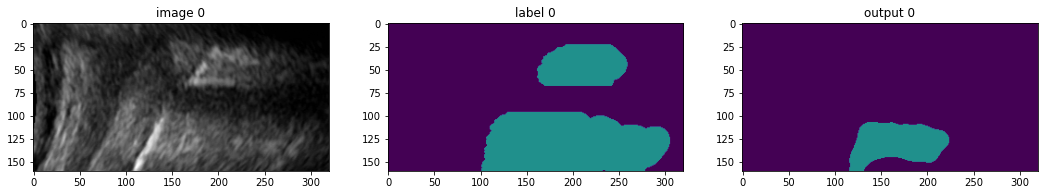

Number of not-sliding / sliding pixel = 257164 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


026ns_image_1087766719219_clean.nii.gz


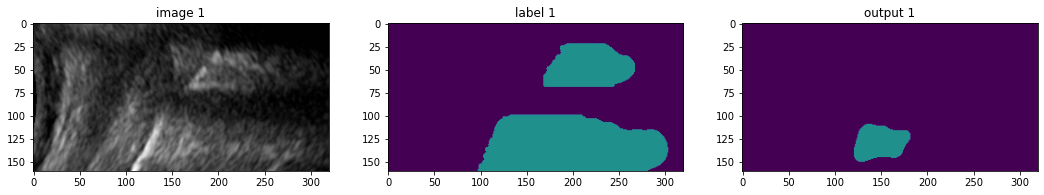

Number of not-sliding / sliding pixel = 158200 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FP ROI = 019s_iimage_10705997566592_CLEAN.nii.gz
019s_iimage_10705997566592_CLEAN.nii.gz


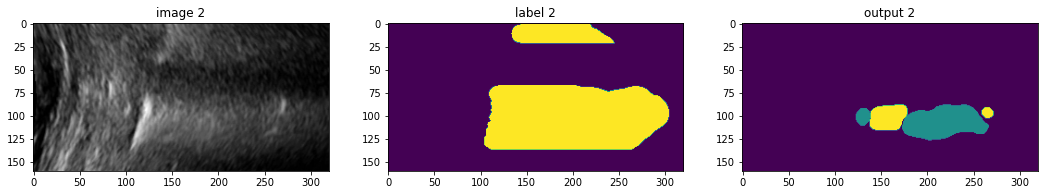

Number of not-sliding / sliding pixel = 254526 44722
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 019s_iimage_10705997566592_CLEAN.nii.gz


019s_iimage_10891015221417_clean.nii.gz


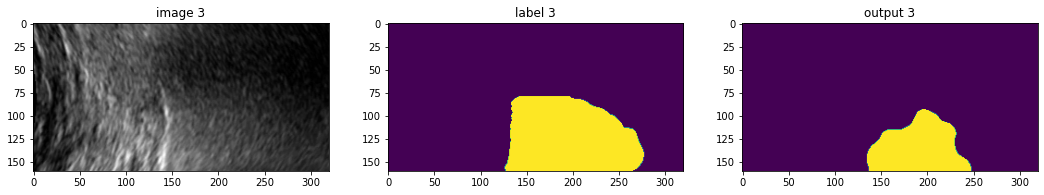

Number of not-sliding / sliding pixel = 0 313751
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 3 of 15


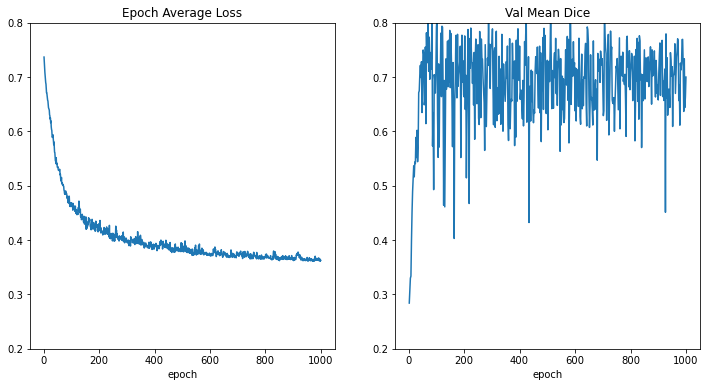

027ns_image_4641643404894_CLEAN.nii.gz


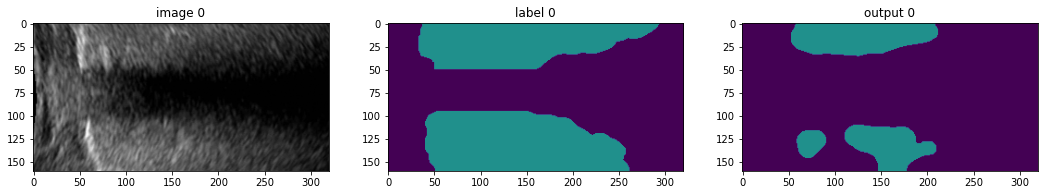

Number of not-sliding / sliding pixel = 539231 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


027ns_image_4743880599022_clean.nii.gz


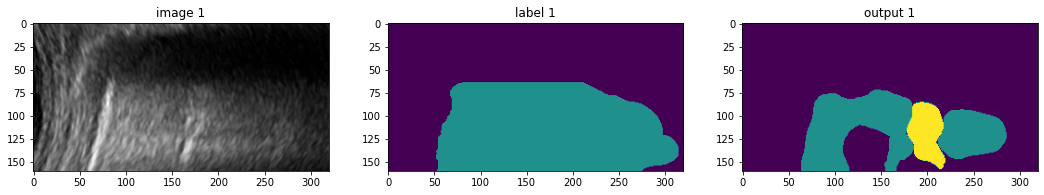

Number of not-sliding / sliding pixel = 611445 182941
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


030s_iimage_1180496934444_clean.nii.gz


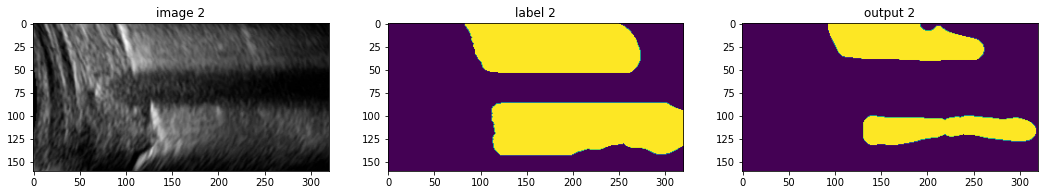

Number of not-sliding / sliding pixel = 0 575122
    Min thresh = 1000
    Sliding


  Winner = Sliding


030s_iimage_677741729740_clean.nii.gz


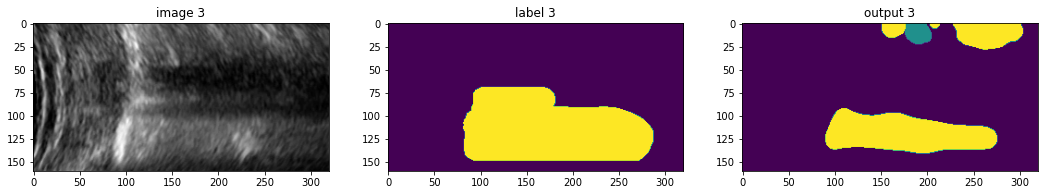

Number of not-sliding / sliding pixel = 38772 527027
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 4 of 15


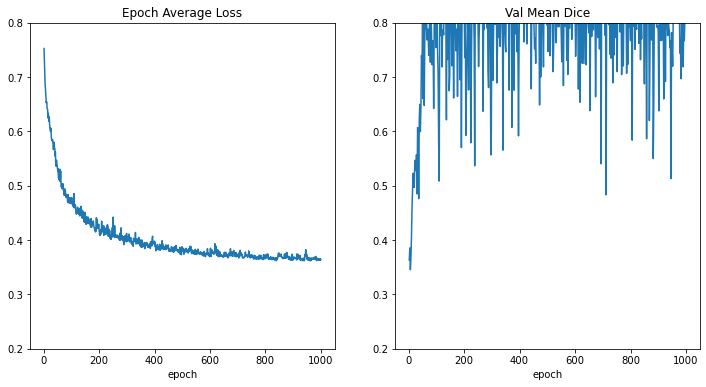

035ns_image_1394469579519_clean.nii.gz


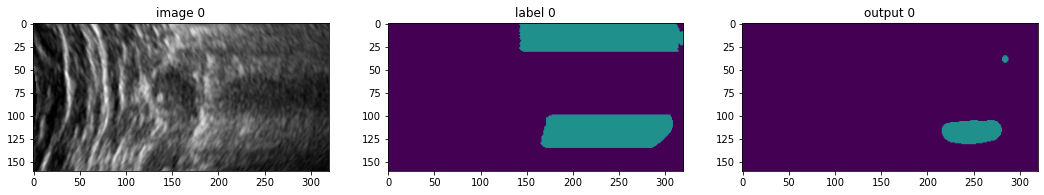

Number of not-sliding / sliding pixel = 63640 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


035ns_image_1404802450036_clean.nii.gz


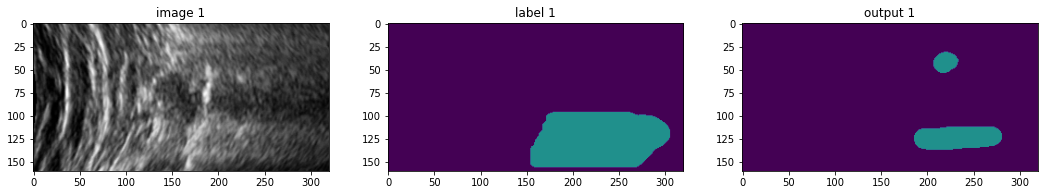

Number of not-sliding / sliding pixel = 127810 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


034s_iimage_3368391807672_clean.nii.gz


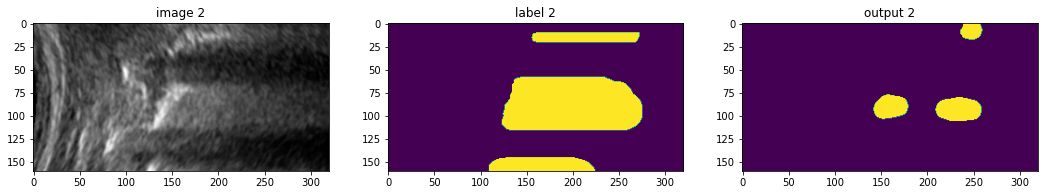

Number of not-sliding / sliding pixel = 0 149013
    Min thresh = 1000
    Sliding


  Winner = Sliding


034s_iimage_3401832241774_clean.nii.gz


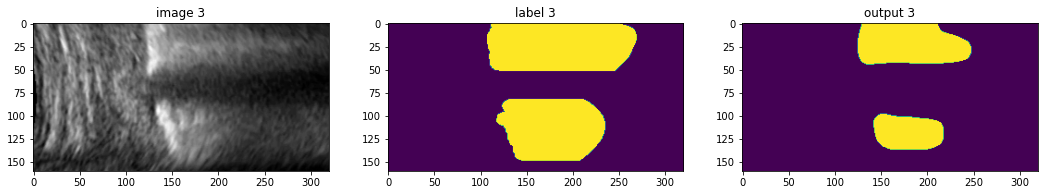

Number of not-sliding / sliding pixel = 0 423842
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 5 of 15


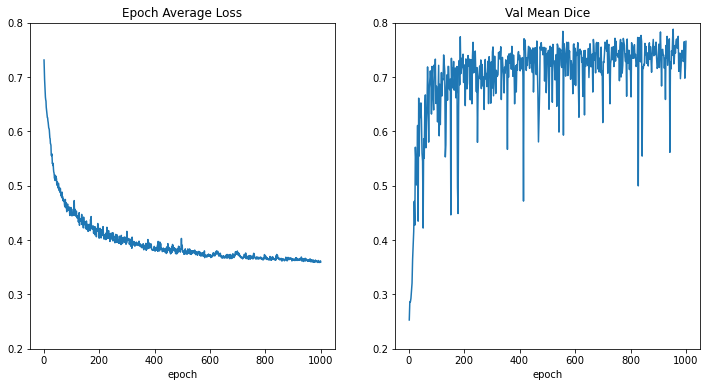

      FN ROI = 048ns_image_1543571117118_clean.nii.gz
048ns_image_1543571117118_clean.nii.gz


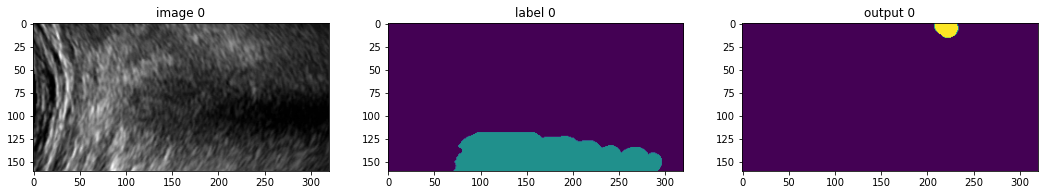

Number of not-sliding / sliding pixel = 0 10587
    Min thresh = 1000
    Sliding


  Winner = Sliding
 FN Patient = 048ns_image_1543571117118_clean.nii.gz


048ns_image_1749559540112_clean.nii.gz


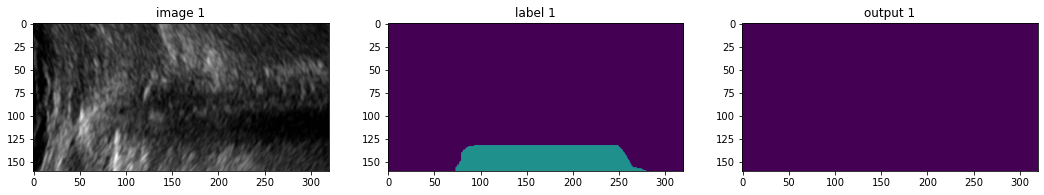

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FP ROI = 037s_iimage_588413346180_CLEAN.nii.gz
037s_iimage_588413346180_CLEAN.nii.gz


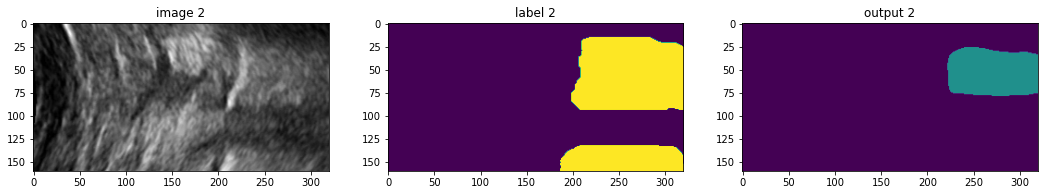

Number of not-sliding / sliding pixel = 274781 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


   VFOLD = 6 of 15


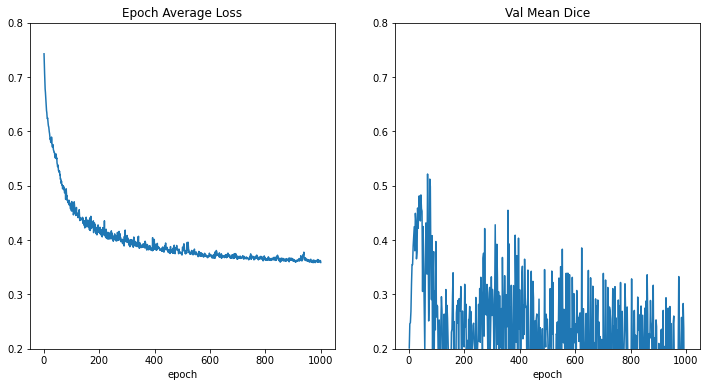

055ns_image_27180764486244_CLEAN.nii.gz


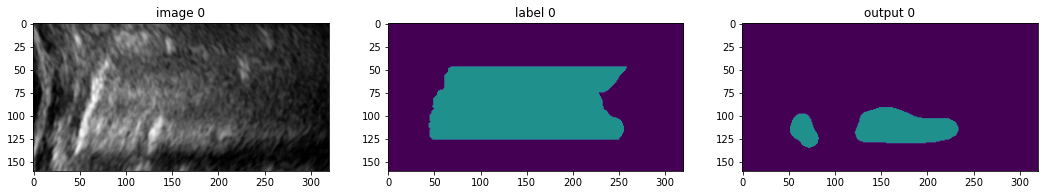

Number of not-sliding / sliding pixel = 259048 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


055ns_image_27185428518326_CLEAN.nii.gz


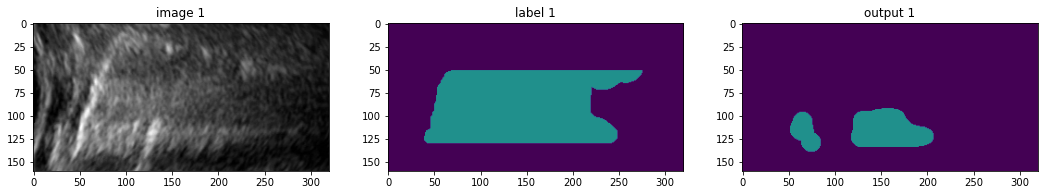

Number of not-sliding / sliding pixel = 243446 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


043s_iimage_10391571128899_CLEAN.nii.gz


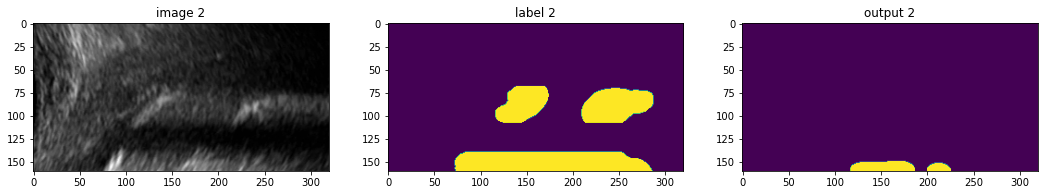

Number of not-sliding / sliding pixel = 0 68035
    Min thresh = 1000
    Sliding


  Winner = Sliding


043s_iimage_10395655826502_CLEAN.nii.gz


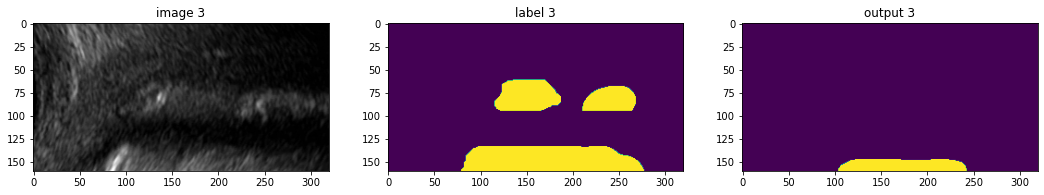

Number of not-sliding / sliding pixel = 0 105462
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 7 of 15


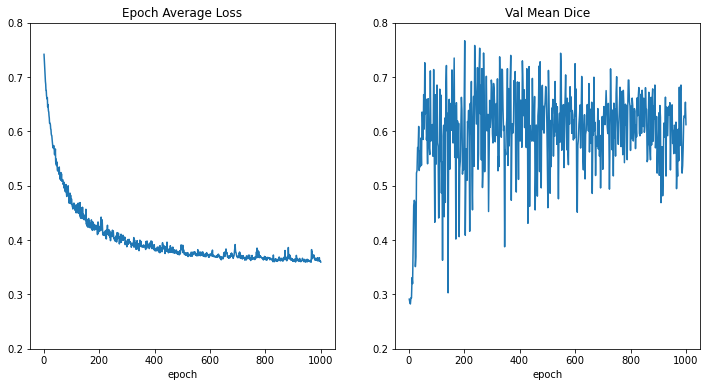

117ns_image_417221672548_CLEAN.nii.gz


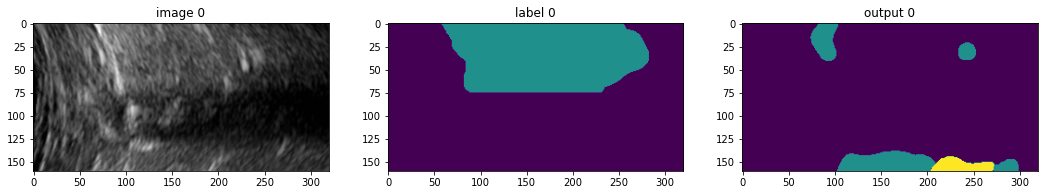

Number of not-sliding / sliding pixel = 187339 96848
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


117ns_image_426794579576_CLEAN.nii.gz


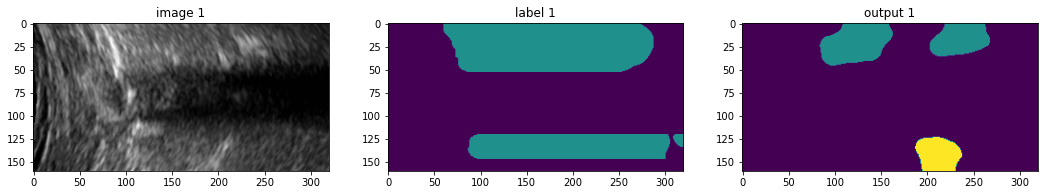

Number of not-sliding / sliding pixel = 307828 110310
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


065s_iimage_1896534330004_clean.nii.gz


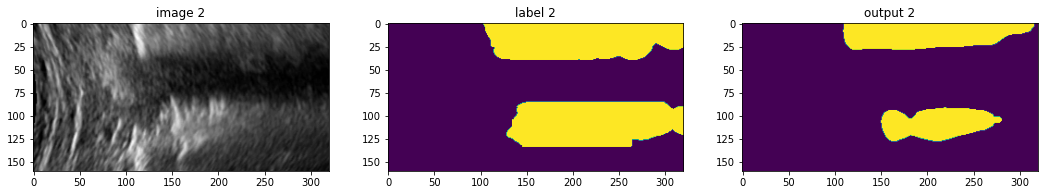

Number of not-sliding / sliding pixel = 0 510713
    Min thresh = 1000
    Sliding


  Winner = Sliding


065s_iimage_1901852337971_clean.nii.gz


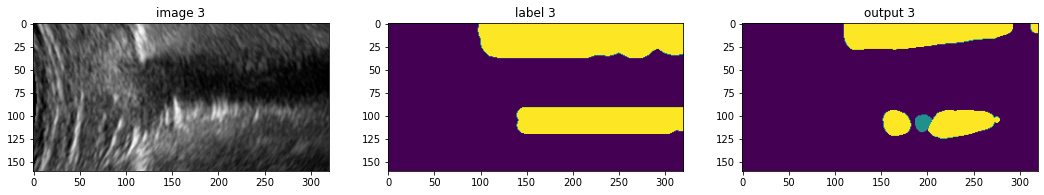

Number of not-sliding / sliding pixel = 29072 430792
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 8 of 15


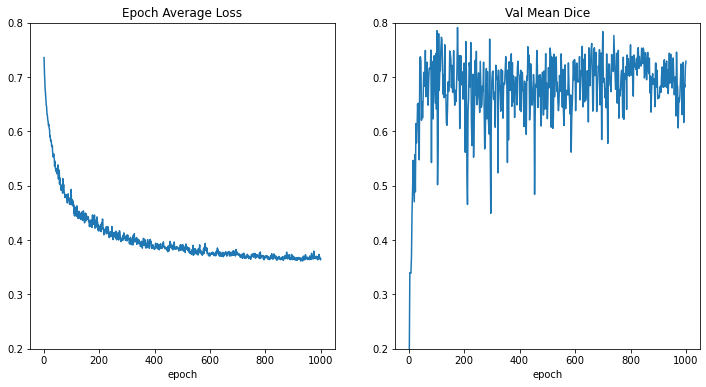

      FN ROI = 135ns_image_2418161753608_clean.nii.gz
135ns_image_2418161753608_clean.nii.gz


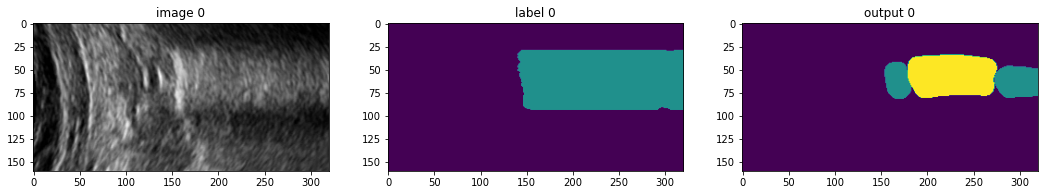

Number of not-sliding / sliding pixel = 127407 228771
    Min thresh = 1000
    Sliding


  Winner = Sliding
 FN Patient = 135ns_image_2418161753608_clean.nii.gz


135ns_image_2454526567135_CLEAN.nii.gz


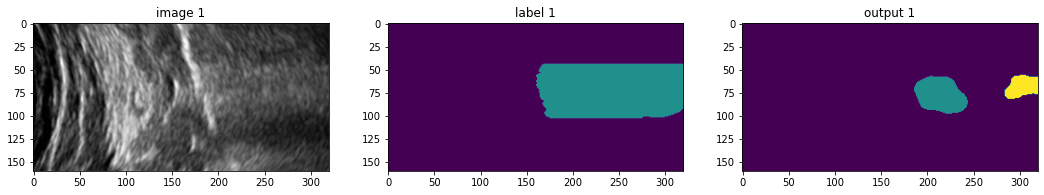

Number of not-sliding / sliding pixel = 109149 30032
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


081s_iimage_2959672151786_clean.nii.gz


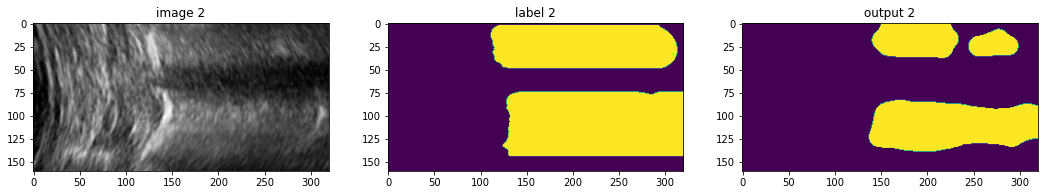

Number of not-sliding / sliding pixel = 0 776530
    Min thresh = 1000
    Sliding


  Winner = Sliding


081s_iimage_3320344386805_clean.nii.gz


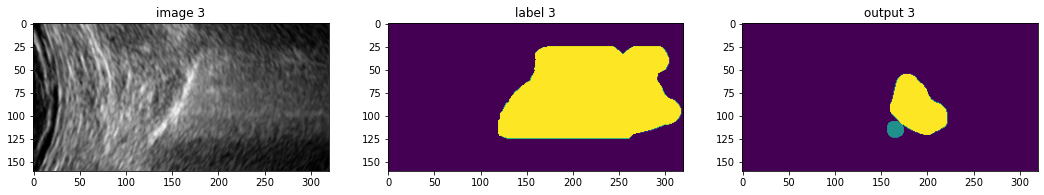

Number of not-sliding / sliding pixel = 18509 161139
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 9 of 15


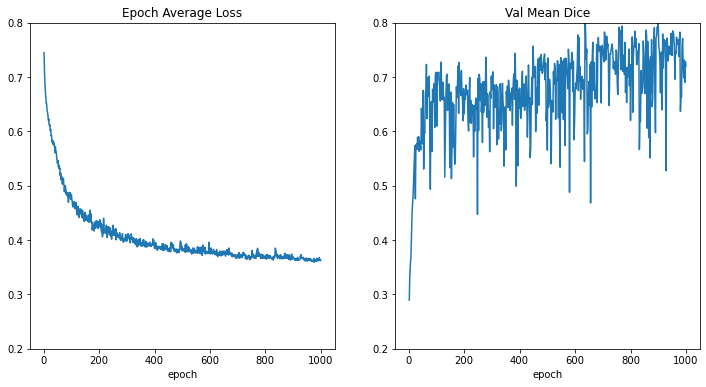

193ns_image_634125159704_CLEAN.nii.gz


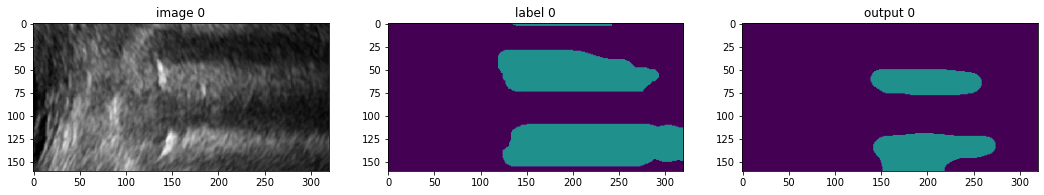

Number of not-sliding / sliding pixel = 403711 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


193ns_image_642169070951_clean.nii.gz


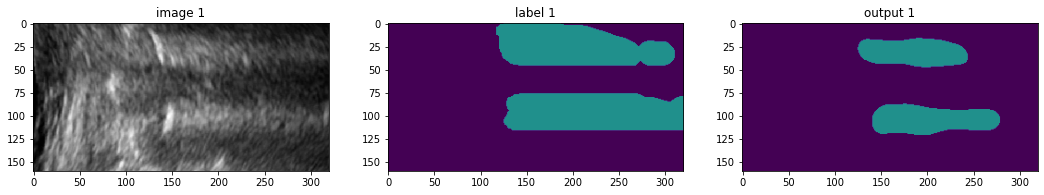

Number of not-sliding / sliding pixel = 371065 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


206s_iimage_1499268364374_clean.nii.gz


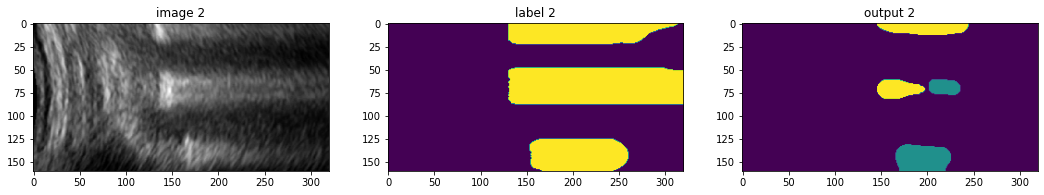

Number of not-sliding / sliding pixel = 103498 135155
    Min thresh = 1000
    Sliding


  Winner = Sliding


206s_iimage_1511338287338_clean.nii.gz


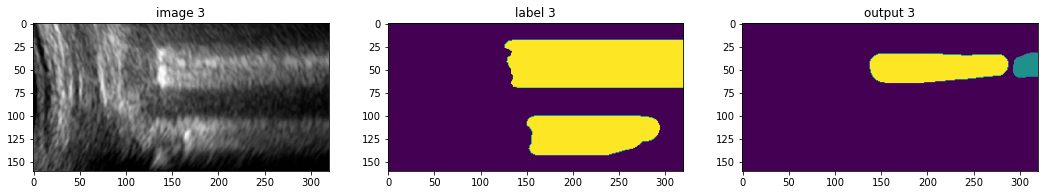

Number of not-sliding / sliding pixel = 25200 263726
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 10 of 15


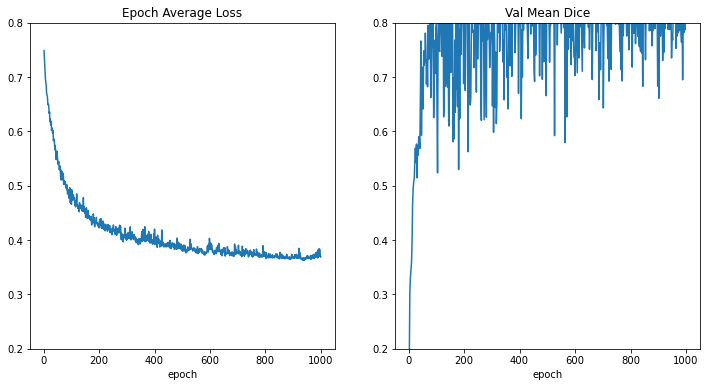

210ns_image_603665940081_clean.nii.gz


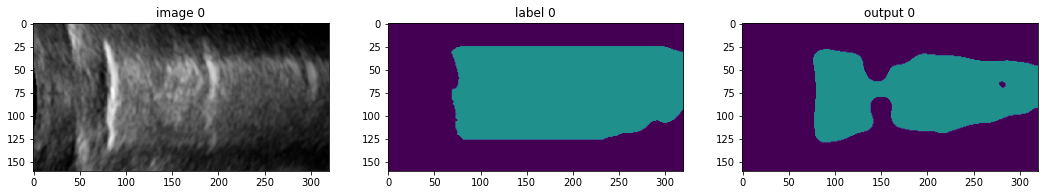

Number of not-sliding / sliding pixel = 1009626 4996
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


210ns_image_614587120545_clean.nii.gz


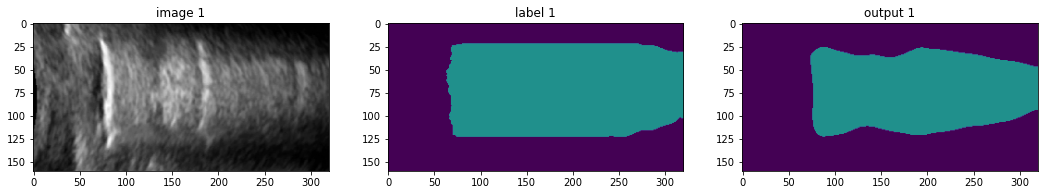

Number of not-sliding / sliding pixel = 1109256 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


208s_iimage_104543812690743_CLEAN.nii.gz


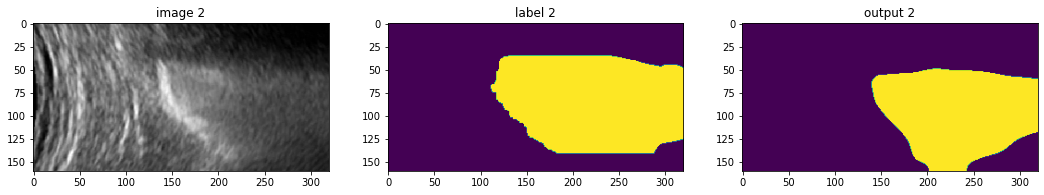

Number of not-sliding / sliding pixel = 0 871493
    Min thresh = 1000
    Sliding


  Winner = Sliding


208s_iimage_104548309385533_CLEAN.nii.gz


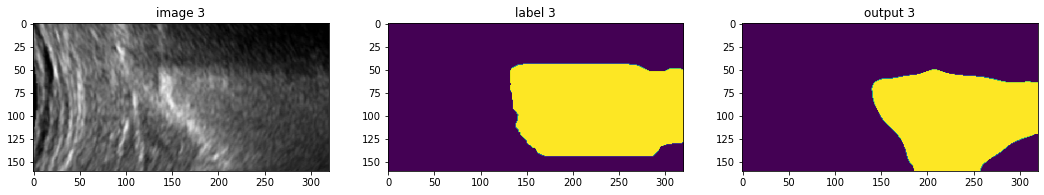

Number of not-sliding / sliding pixel = 0 891107
    Min thresh = 1000
    Sliding


  Winner = Sliding


208s_iimage_104932526155699_CLEAN.nii.gz


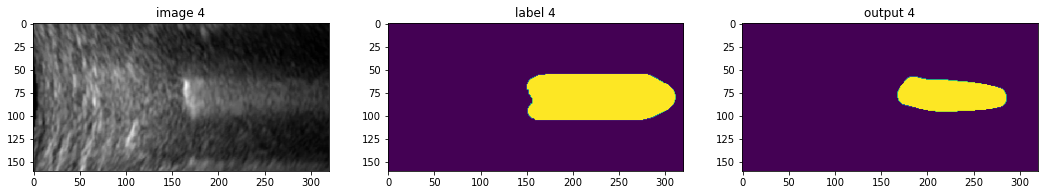

Number of not-sliding / sliding pixel = 0 198995
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 11 of 15


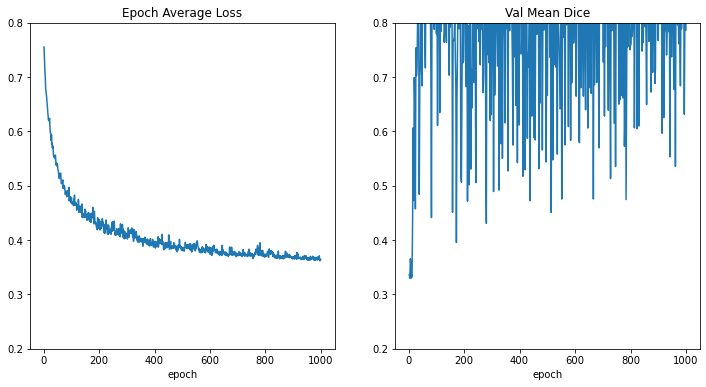

215ns_image_573611404207_CLEAN.nii.gz


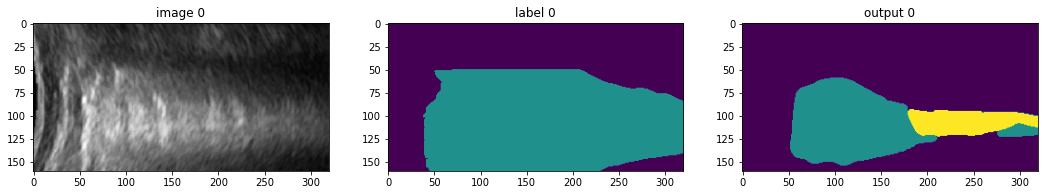

Number of not-sliding / sliding pixel = 781285 172590
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FN ROI = 215ns_image_610066411380_CLEAN.nii.gz
215ns_image_610066411380_CLEAN.nii.gz


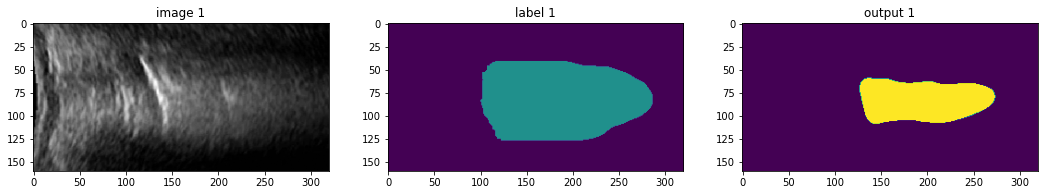

Number of not-sliding / sliding pixel = 0 355811
    Min thresh = 1000
    Sliding


  Winner = Sliding
 FN Patient = 215ns_image_610066411380_CLEAN.nii.gz


211s_iimage_3925135436261_clean.nii.gz


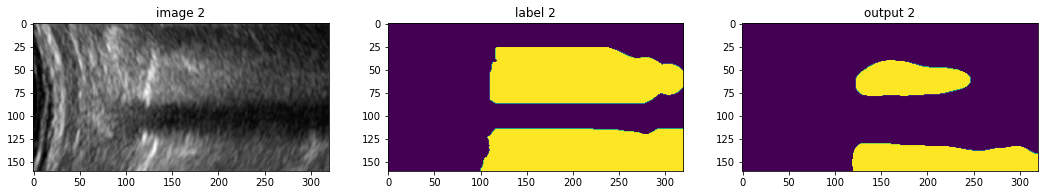

Number of not-sliding / sliding pixel = 0 527948
    Min thresh = 1000
    Sliding


  Winner = Sliding


211s_iimage_3929217595322_clean.nii.gz


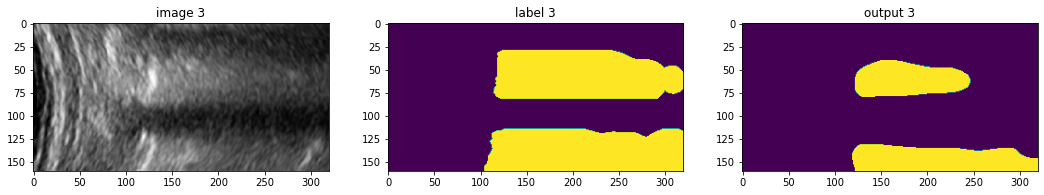

Number of not-sliding / sliding pixel = 0 508190
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 12 of 15


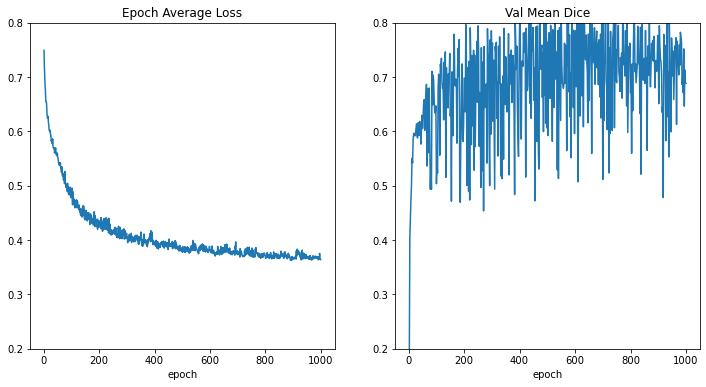

218ns_image_6056976176281_CLEAN.nii.gz


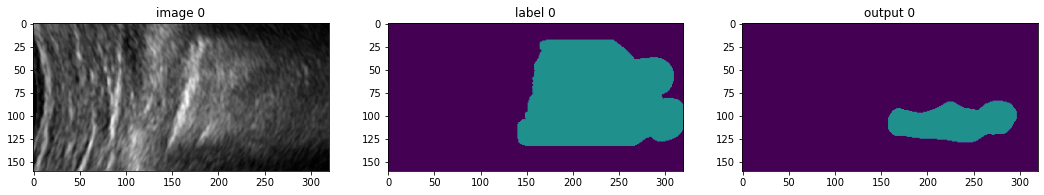

Number of not-sliding / sliding pixel = 253690 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


218ns_image_6370410622099_CLEAN.nii.gz


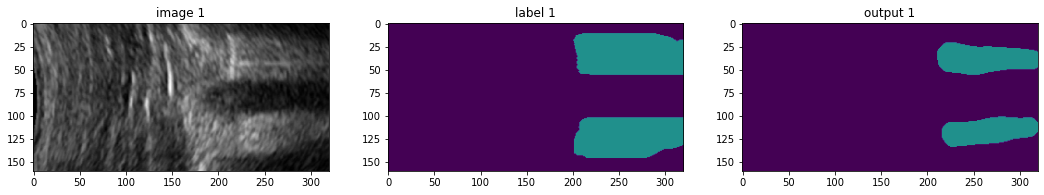

Number of not-sliding / sliding pixel = 313554 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FP ROI = 212s_iimage_128683942015128_CLEAN.nii.gz
212s_iimage_128683942015128_CLEAN.nii.gz


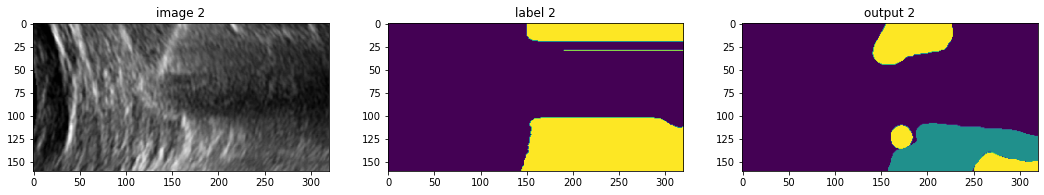

Number of not-sliding / sliding pixel = 360670 203613
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 212s_iimage_128683942015128_CLEAN.nii.gz


      FP ROI = 212s_iimage_128688523296793_CLEAN.nii.gz
212s_iimage_128688523296793_CLEAN.nii.gz


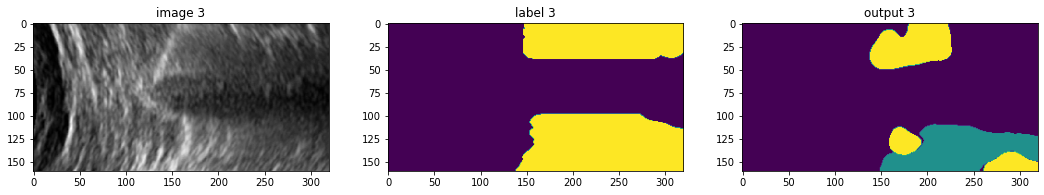

Number of not-sliding / sliding pixel = 341592 242242
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 212s_iimage_128688523296793_CLEAN.nii.gz


212s_iimage_128692595484031_CLEAN.nii.gz


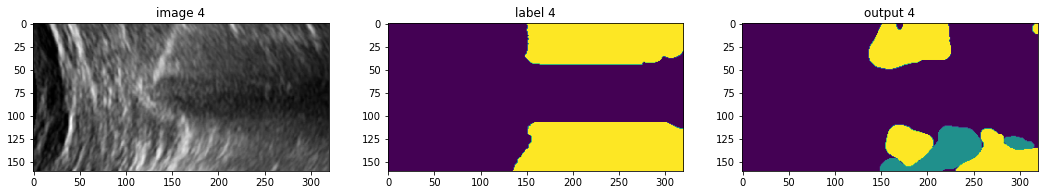

Number of not-sliding / sliding pixel = 270499 361408
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 13 of 15


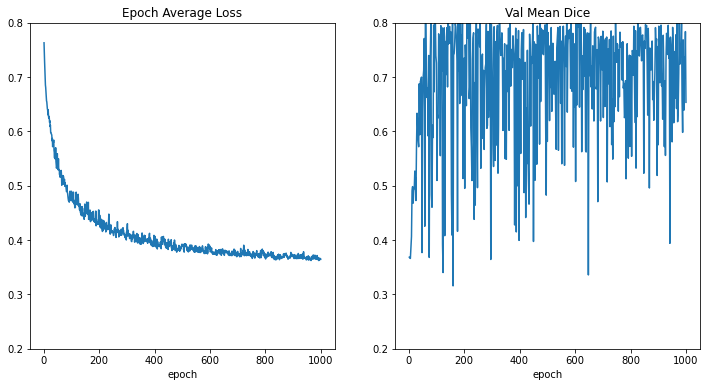

219ns_image_1884162273498_clean.nii.gz


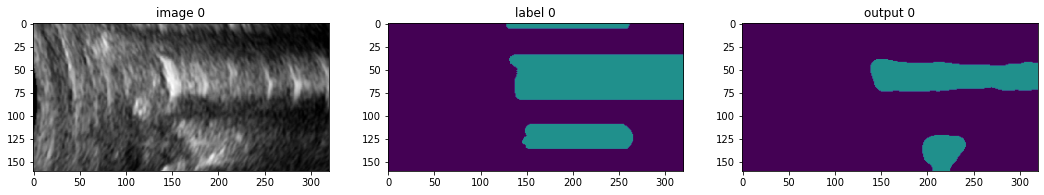

Number of not-sliding / sliding pixel = 310068 55442
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


219ns_image_1895283541879_clean.nii.gz


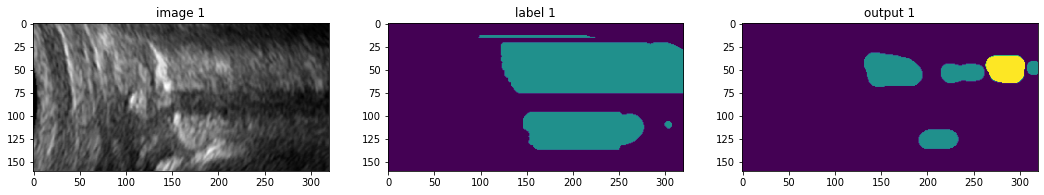

Number of not-sliding / sliding pixel = 204273 59994
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


224s_iimage_3308406916756_clean.nii.gz


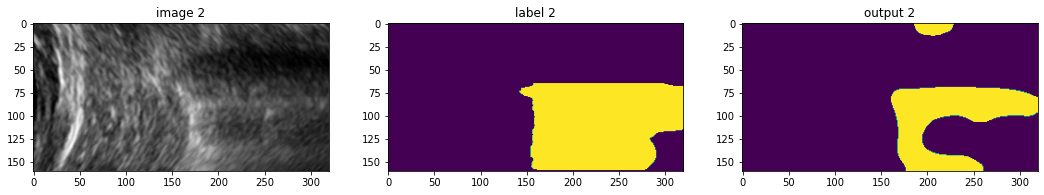

Number of not-sliding / sliding pixel = 18849 471871
    Min thresh = 1000
    Sliding


  Winner = Sliding


224s_iimage_3315947589826_clean.nii.gz


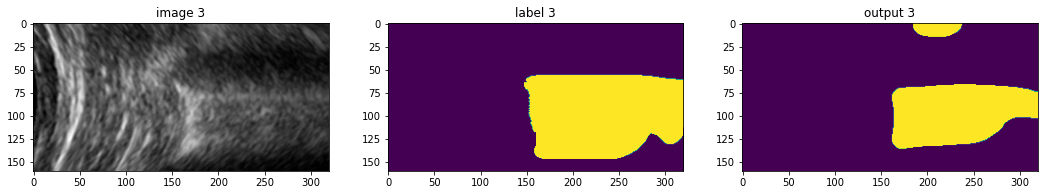

Number of not-sliding / sliding pixel = 0 560660
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 14 of 15


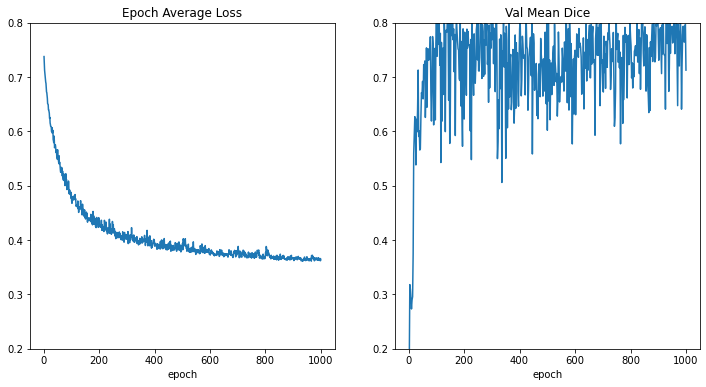

221ns_image_584357289931_clean.nii.gz


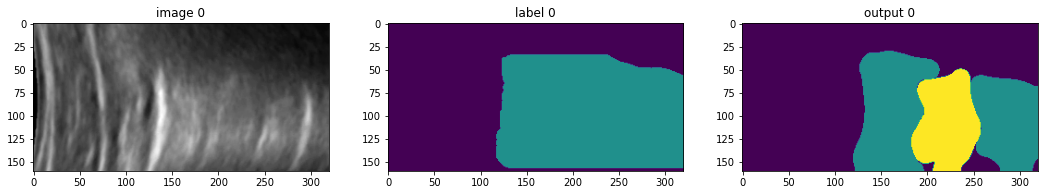

Number of not-sliding / sliding pixel = 864393 322526
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


221ns_image_588695055398_clean.nii.gz


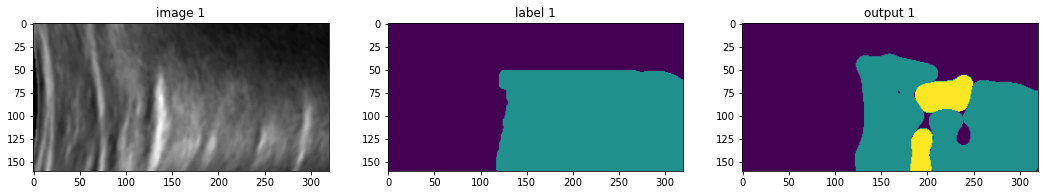

Number of not-sliding / sliding pixel = 985737 170969
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


228s_iimage_3321463845606_clean.nii.gz


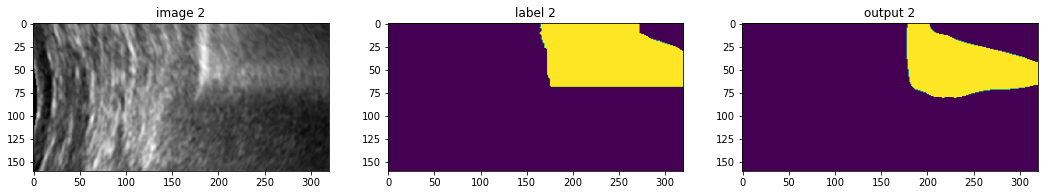

Number of not-sliding / sliding pixel = 38368 502346
    Min thresh = 1000
    Sliding


  Winner = Sliding


      FP ROI = 228s_iimage_3384882513134_clean.nii.gz
228s_iimage_3384882513134_clean.nii.gz


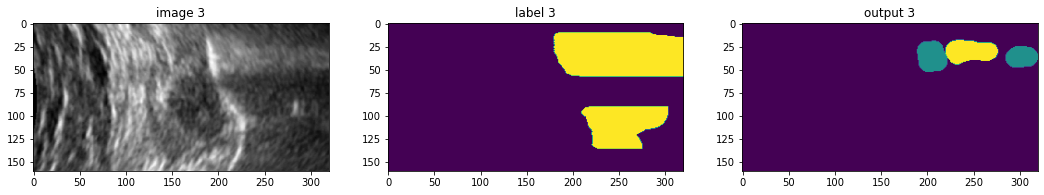

Number of not-sliding / sliding pixel = 98597 51176
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 228s_iimage_3384882513134_clean.nii.gz




Patients: Correct = 52 Incorrect = 10 Not Sliding as Sliding = 3
Slices: Correct = 51 Incorrect =  11 Not Sliding as Sliding = 3
*************


In [15]:
min_size = 1000
min_portion = 0.0

for prior in [[1.3,1.0,0.9]]: #[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
    print('*************')
    print("Prior =", prior)
    correct = 0
    incorrect = 0
    false_negatives = 0
    slice_correct = 0
    slice_incorrect = 0
    slice_false_negatives = 0
    for i in range(num_folds):
        (fcorrect, fincorrect, ffalse_negatives, fslice_correct, fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i],
            min_size, min_portion, prior, True)
        correct += fcorrect
        incorrect += fincorrect
        false_negatives += ffalse_negatives
        slice_correct += fslice_correct
        slice_incorrect += fslice_incorrect
        slice_false_negatives += fslice_false_negatives
    print()
    print()
    print("Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
    print("Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)
    print('*************')
